# Spectral Parameterization


***

![voyteklab](./data/voyteklab.png)

***


## Fitting Algorithm

A step-by-step overview of the algorithm for parameterizing neural power spectra. Based on the method described in: 


Donoghue T, Haller M, Peterson EJ, Varma P, Sebastian P, Gao R, Noto T, Lara AH, Wallis JD,
Knight RT, Shestyuk A, & Voytek B (2020). Parameterizing neural power spectra into periodic
and aperiodic components. *Nature Neuroscience, 23*, 1655-1665.
[DOI: 10.1038/s41593-020-00744-x](https://doi.org/10.1038/s41593-020-00744-x) 

Tutorial originally authored by Thomas Donoghue. Adapted for SPR 2022 by Sydney Smith, Eena Kosik, and Quirine Van Engen.

### Algorithmic Description

In this tutorial, we will step through how the power spectrum model is fit.

Note that this notebook is for demonstrative purposes, and does not represent
recommended usage of how to fit power spectrum models.

Broadly, the steps in the algorithm are:

1. An initial fit of the aperiodic component is computed from the power spectrum.
2. This aperiodic fit is subtracted from the power spectrum, creating a flattened spectrum.
3. An iterative process identifies peaks in this flattened spectrum.
4. A full peak fit is re-fit from all of the identified peak candidates.
5. The peak fit is subtracted from the original power spectrum, creating a peak-removed power spectrum.
6. A final fit of the aperiodic component is taken of the peak-removed power spectrum.
7. The full model is reconstructed from the combination of the aperiodic and peak fits, and goodness of fit metrics are calculated.



### Setup

In [1]:
# General imports
import matplotlib.pyplot as plt

# Import the FOOOF object
from fooof import FOOOF

# Import some internal functions. These are used here to demonstrate the algorithm.
# You do not need to import these functions for standard usage of the module
from fooof.sim.gen import gen_aperiodic
from fooof.plts.spectra import plot_spectrum
from fooof.plts.annotate import plot_annotated_peak_search

# Import a utility to download and load example data
from fooof.utils.download import load_fooof_data

In [2]:
# Set whether to plot in log-log space
plt_log = False

In [3]:
# Load example data files needed for this example
freqs = load_fooof_data('freqs_2.npy', folder='data')
spectrum = load_fooof_data('spectrum_2.npy', folder='data')

In [4]:
# Initialize a FOOOF object, with some settings. 
# These settings will be more fully described later in the tutorials
fm = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_height=0.15)

Note that data can be added to a FOOOF object independent of fitting the model, using the
:meth:`~fooof.FOOOF.add_data` method. FOOOF objects can also be used to plot data,
prior to fitting any models.




In [5]:
# Add data to the object
fm.add_data(freqs, spectrum, [3, 40])

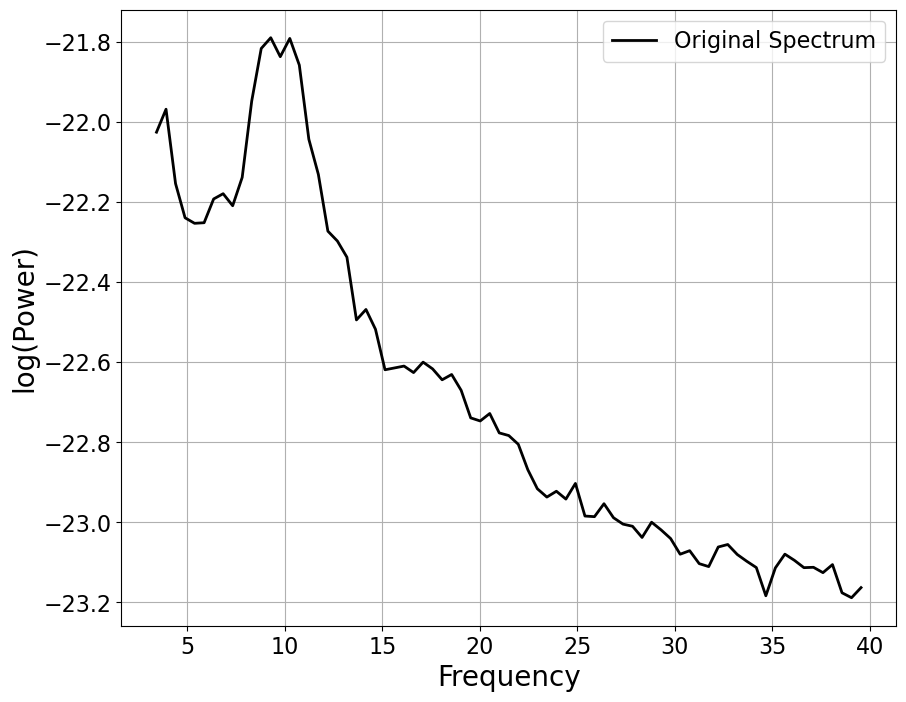

In [6]:
# Plot the power spectrum
fm.plot(plt_log)

The FOOOF object stores most of the intermediate steps internally.

For this notebook, we will first fit the full model, as normal, but then step through,
and visualize each step the algorithm took to come to that final fit.




In [7]:
# Fit the power spectrum model
fm.fit(freqs, spectrum, [3, 40])

***

<br/><br/>

## Step 1: Initial Aperiodic Fit

We start by taking an initial aperiodic fit. This goal of this fit is to get an initial
fit that is good enough to get started with the fitting process.


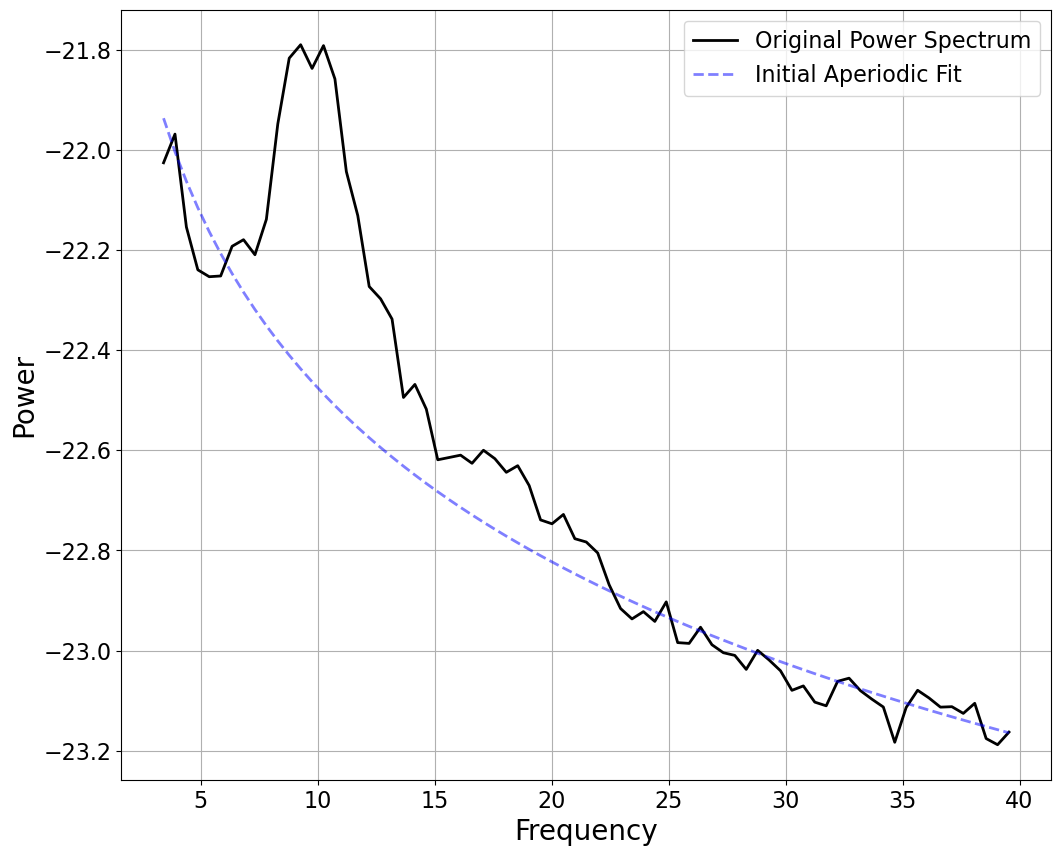

In [8]:
# Do an initial aperiodic fit - a robust fit, that excludes outliers. 
# This recreates an initial fit that isn't ultimately stored in the FOOOF object
init_ap_fit = gen_aperiodic(fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum))

# Plot the initial aperiodic fit
_, ax = plt.subplots(figsize=(12, 10))
plot_spectrum(fm.freqs, fm.power_spectrum, plt_log,
              label='Original Power Spectrum', color='black', ax=ax)
plot_spectrum(fm.freqs, init_ap_fit, plt_log, label='Initial Aperiodic Fit',
              color='blue', alpha=0.5, linestyle='dashed', ax=ax)


***

<br/><br/>

## Step 2: Flatten the Spectrum

The initial fit is then used to create a flattened spectrum.

The initial aperiodic fit is subtracted out from the original data, leaving a flattened
version of the data which no longer contains the aperiodic component.




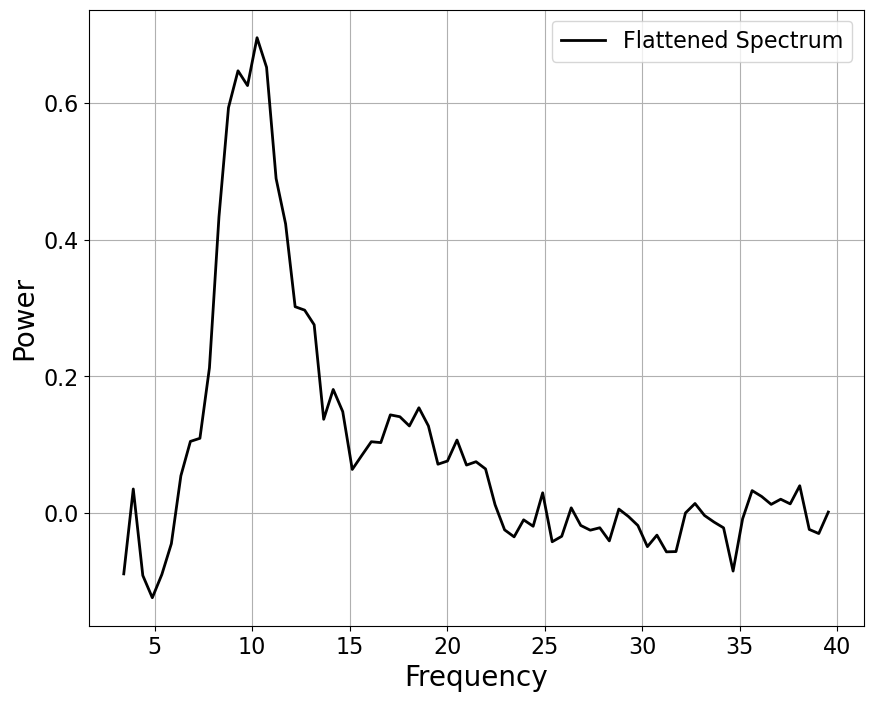

In [9]:
# Recompute the flattened spectrum using the initial aperiodic fit
init_flat_spec = fm.power_spectrum - init_ap_fit

# Plot the flattened the power spectrum
plot_spectrum(fm.freqs, init_flat_spec, plt_log,
              label='Flattened Spectrum', color='black')

***

<br/><br/>

## Step 3: Detect Peaks


The flattened spectrum is then used to detect peaks. We can better isolate
peaks in the data, as the aperiodic activity has been removed.

The fitting algorithm uses an iterative procedure to find peaks in the flattened spectrum.

For each iteration:
- The maximum point of the flattened spectrum is found
  - If this point fails to pass the relative or absolute height threshold,
    the procedure halts
- A Gaussian is fit around this maximum point
- This 'guess' Gaussian is then subtracted from the flatted spectrum
- The procedure continues to a new iteration with the new version of the flattened spectrum,
  unless `max_n_peaks` has been reached




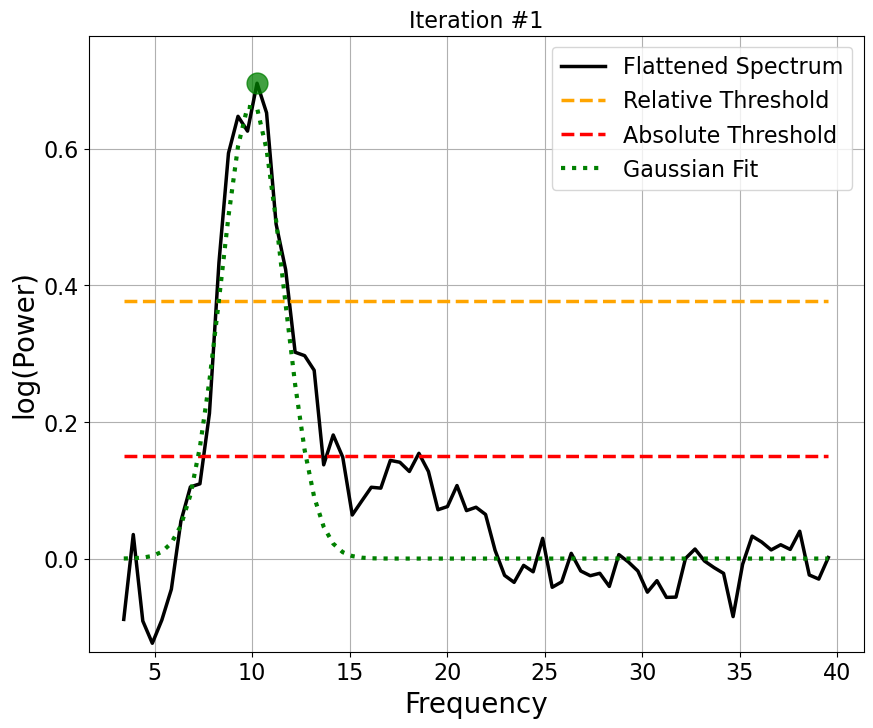

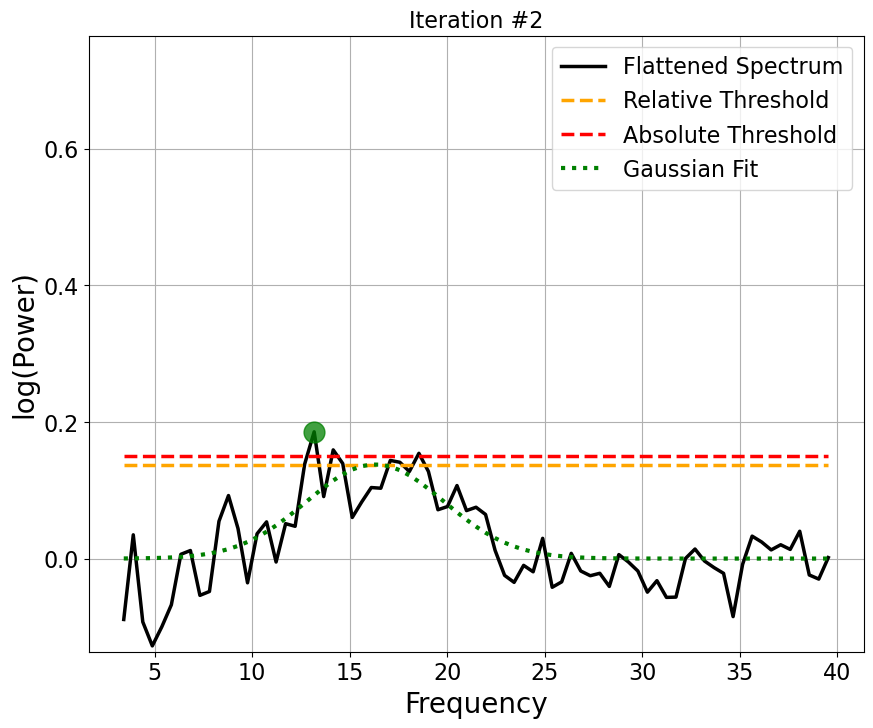

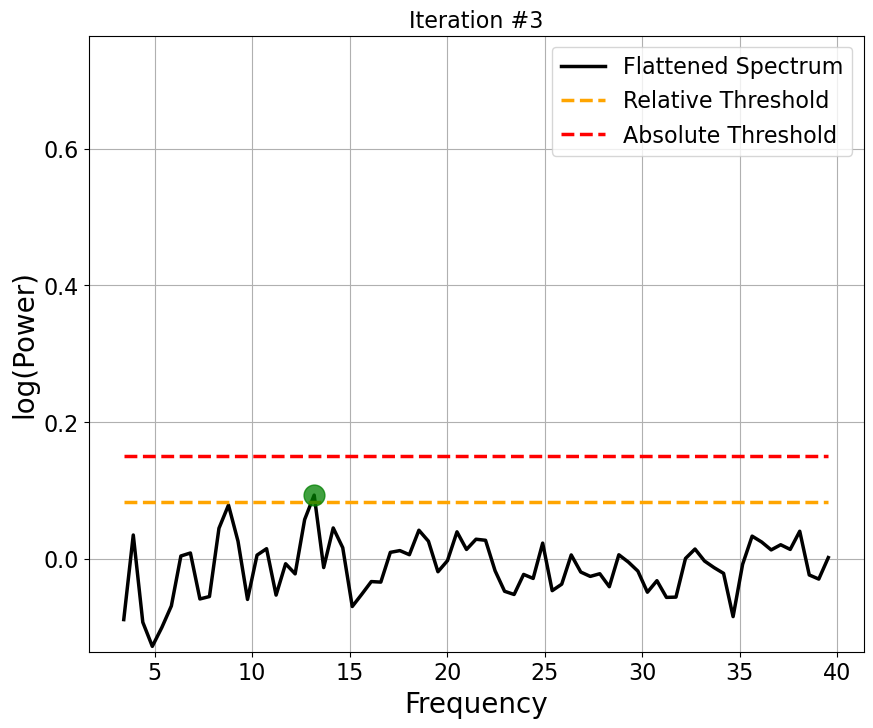

In [10]:
# Plot the iterative approach to finding peaks from the flattened spectrum
plot_annotated_peak_search(fm)

*NOTE:*

The **relative threshold** is set in terms of standard deviations of the flattened power spectrum. By default, the FOOOF algorithm has a relative peak detection threshold of 2 standard deviations.

The **absolute thredhold** is a minimum power threshold that a point in the flattened spectrum must surpass to be identified as a peak. Here, the absolute threshold is set to 0.15 $\mu V^2$.

Both relative threshold ``peak_threshold`` and absolute threshold ``min_peak_height`` can be set as parameters in the model initialization step.

***

<br/><br/>

## Step 4: Create Full Peak Fit


Once the iterative procedure has halted and the peaks have been identified in the
flattened spectrum, the set of identified 'guess' peaks, are then re-fit, all together.
This creates the full peak fit of the data.




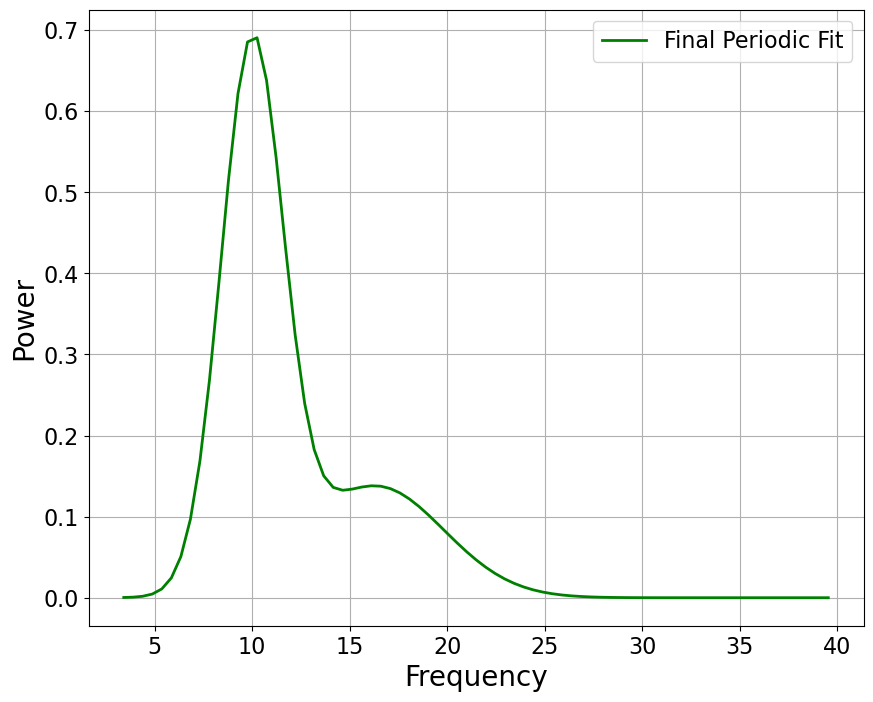

In [11]:
# Plot the peak fit: created by re-fitting all of the candidate peaks together
plot_spectrum(fm.freqs, fm._peak_fit, plt_log, color='green', label='Final Periodic Fit')

***

<br/><br/>

## Step 5: Create a Peak-Removed Spectrum


Now that the peak component of the fit is completed and available, this fit is then
used in order to try and isolate a better aperiodic fit.

To do so, the peak fit is removed from the original power spectrum,
leaving an 'aperiodic-only' spectrum for re-fitting.



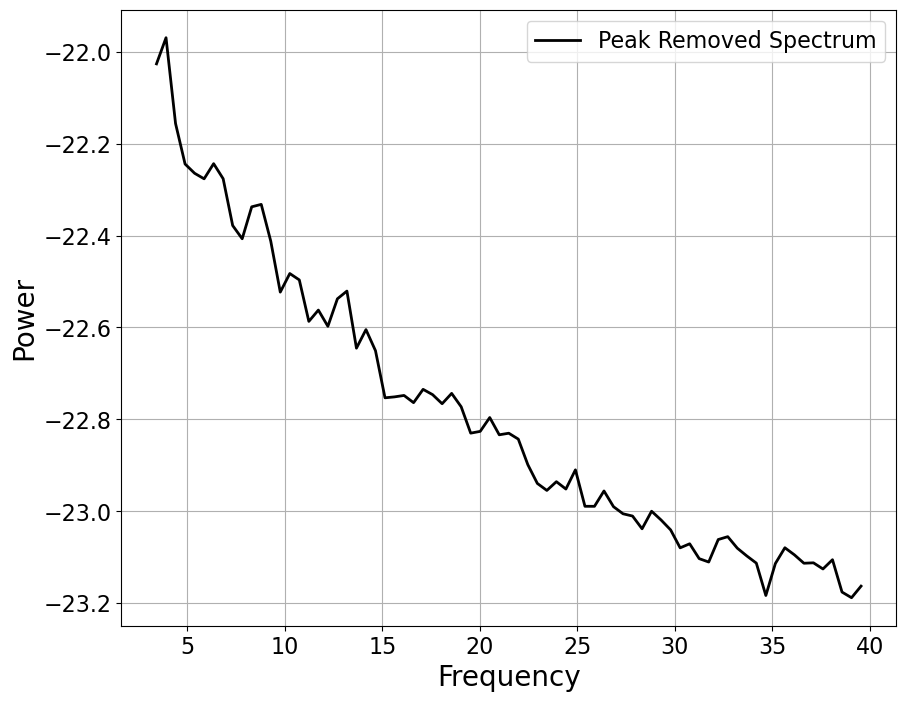

In [12]:
# Plot the peak removed power spectrum, created by removing peak fit from original spectrum
plot_spectrum(fm.freqs, fm._spectrum_peak_rm, plt_log,
              label='Peak Removed Spectrum', color='black')

***

<br/><br/> 

## Step 6: Re-fit the Aperiodic Component


The initial aperiodic component fit we made was a robust fit approach that was
used to get the fitting process started.

With the peak-removed spectrum, we can now re-fit the aperiodic component, to
re-estimate a better fit, without the peaks getting in the way.





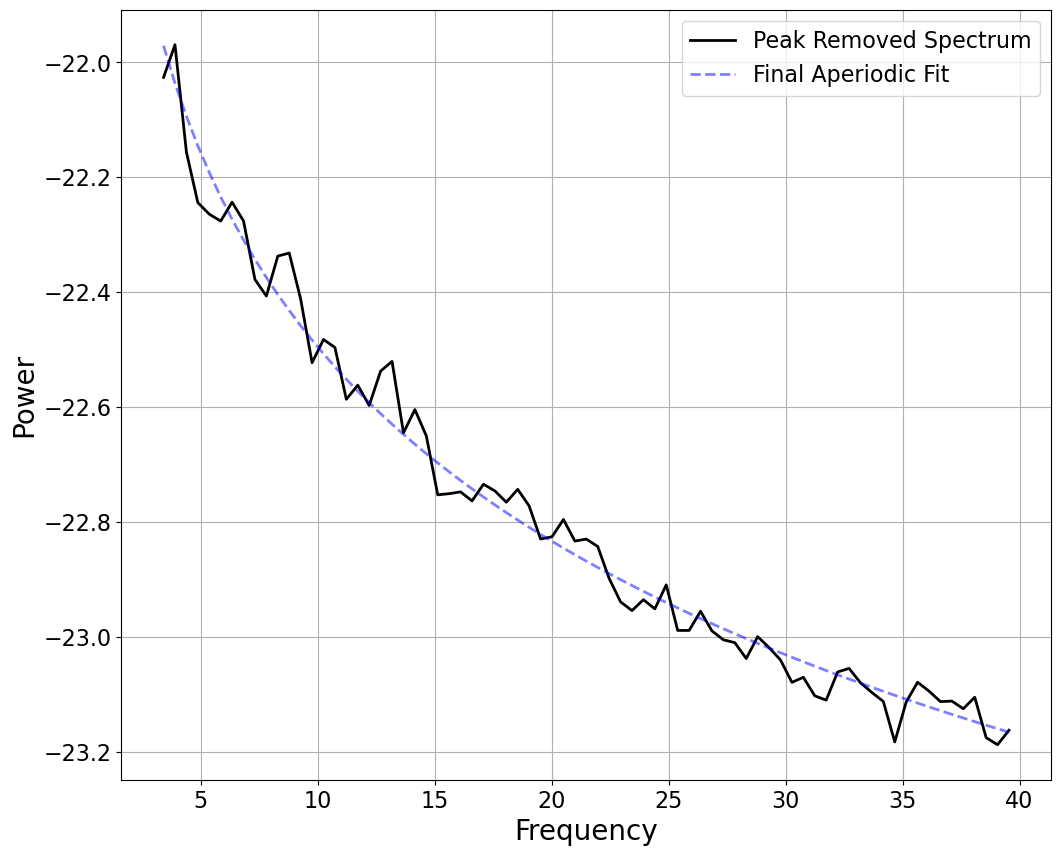

In [13]:
# Plot the final aperiodic fit, calculated on the peak removed power spectrum
_, ax = plt.subplots(figsize=(12, 10))
plot_spectrum(fm.freqs, fm._spectrum_peak_rm, plt_log,
              label='Peak Removed Spectrum', color='black', ax=ax)
plot_spectrum(fm.freqs, fm._ap_fit, plt_log, label='Final Aperiodic Fit',
              color='blue', alpha=0.5, linestyle='dashed', ax=ax)

***

<br/><br/>

## Step 7: Combine the Full Model Fit


Now that we have the final aperiodic fit, we can combine the aperiodic components
to create the full model fit.

With this full model fit, we can also calculate the goodness-of-fit metrics,
including the error of the fit and the R-squared of the fit, by comparing the
full model fit to the original data.




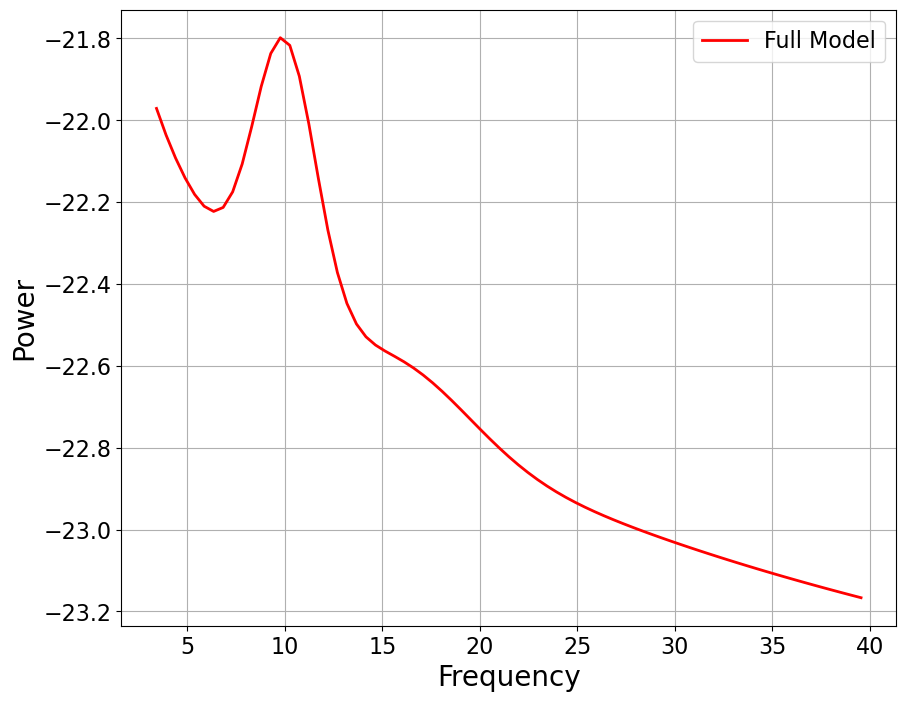

In [14]:
# Plot full model, created by combining the peak and aperiodic fits
plot_spectrum(fm.freqs, fm.fooofed_spectrum_, plt_log,
              label='Full Model', color='red')

The last stage is to calculate the goodness-of-fit metrics, meaning the fit error & $R^2$.

At the end of the fitting process, the model object also organizes parameters, such as
updating gaussian parameters to be peak parameters,

These results are part of what are stored, and printed, as the model results.




In [15]:
# Print out the model results
fm.print_results()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.49 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -21.3713, 1.1239                                         
                                                                                                  
                                       2 peaks were found:                                        
          

Altogether, the full model fit is now available, and can be plotted.

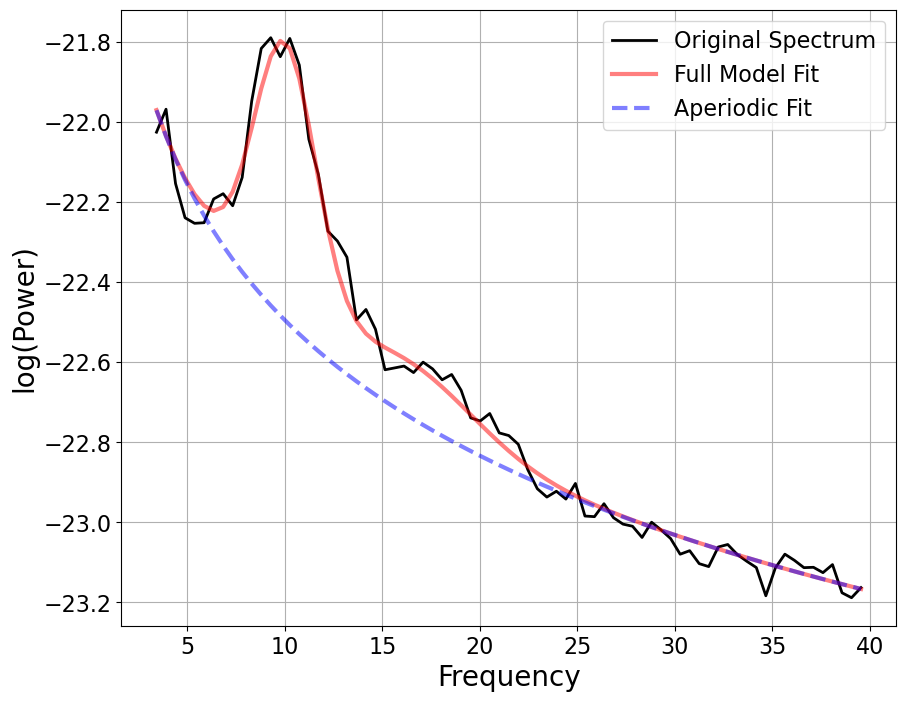

In [16]:
# Plot the full model fit of the power spectrum. The final fit (red), 
# and aperiodic fit (blue), are the same as we plotted above.
fm.plot(plt_log)

***

<br/><br/>


## Conclusion


In this tutorial, we have stepped through the parameterization algorithm for fitting
power spectrum models. Beginning with a power spectrum, FOOOF performs the model fitting algorithm described in this tutorial under the hood; the iterative process here is not plotted by default. The output of the algorithm, the full model fit, includes the parameters for the aperiodic and periodic components of the power spectrum in addition to goodness-of-fit metrics. 

The FOOOF model, various utilities associated with spectral parameterization-based analyses, and other tutorials are documented at the fooof-tools repository and [accompanying API website](https://fooof-tools.github.io/fooof/). 

Next, we will continue to explore the spectral parameterization method using simulated data.




***

<br/><br/>

## Addendum: Data & Model Component Attributes


As you may have noticed through this tutorial, the :class:`~fooof.FOOOF` object keeps
track of some versions of the original data as well as individual model components fits,
as well as the final model fit, the ultimate outcome of the fitting procedure.

These attributes in the FOOOF object are kept at the end of the fitting procedure.
Though they are primarily computed for internal use (hence being considered 'private'
attributes, with the leading underscore), they are accessible and potentially
useful for some analyses, and so are briefly described here.

Stored model components:

- Aperiodic Component: ``_ap_fit``

  - This is the aperiodic-only fit of the data.
  - It is computed by generating a reconstruction of the measured aperiodic parameters

- Periodic Component: ``_peak_fit``

  - This is the periodic-only (or peak) fit of the data.
  - It is computed by generating a reconstruction of the measured periodic (peak) parameters

Stored data attributes:

- Flattened Spectrum: ``_spectrum_flat``

  - The original data, with the aperiodic component removed
  - This is computed as ``power_spectrum`` - ``_ap_fit``

- Peak Removed Spectrum: ``_spectrum_peak_rm``

  - The original data, with the periodic component (peaks) removed
  - This is computed as ``power_spectrum`` - ``_peak_fit``


